In [1]:
import pandas as pd
import numpy as np
import re
import unidecode
from nltk.probability import FreqDist
from nltk.corpus import stopwords as swords
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import stanza
import spacy_stanza
import itertools
import nltk
from nltk.stem import SnowballStemmer
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
df = pd.read_csv("preprocessed.csv")
df = df.dropna(subset=['t6_stemming'])
df.shape

C:\Users\saox\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(108577, 22)

In [3]:
df.head()

,Unnamed: 0,_id,author_parliamentarygroups,created,initiative_type,initiative_type_alt,reference,status,tagged,title,...,tags,topics,history,author_others,place,content,extra,author_deputies,content_coalesce,t6_stemming
0,0,8340a50c3e322491545cf6c40b0b3d29ed03cb85,['Grupo Parlamentario Ciudadanos'],{'$date': '2020-06-02T00:00:00Z'},84,Moción de reprobación a miembros del Gobierno,084/000004,Desconocida,True,"Reprobación del Ministro del Interior, don Fer...",...,[],[],NaN,NaN,NaN,NaN,NaN,NaN,"Reprobación del Ministro del Interior, don Fer...",reprobacion ministr interior don fern grand ma...
1,1,06709837ef704e5aaacfa6ea400517c560ebdd53,['Grupo Parlamentario Republicano'],{'$date': '2021-03-18T00:00:00Z'},84,Moción de reprobación a miembros del Gobierno,084/000022,Desconocida,True,Reprobación de la Ministra de Defensa.,...,[],[],NaN,NaN,NaN,NaN,NaN,NaN,Reprobación de la Ministra de Defensa.,reprobacion ministr defens
2,2,08cee188414ee529ca4dc998340791bae832029f,['Grupo Parlamentario Popular'],{'$date': '2021-03-25T00:00:00Z'},84,Moción de reprobación a miembros del Gobierno,084/000023,Desconocida,True,Reprobación de la Ministra de Educación y Form...,...,[],[],NaN,NaN,NaN,NaN,NaN,NaN,Reprobación de la Ministra de Educación y Form...,reprobacion ministr educacion formacion profes...
3,3,70e6ca135dfb404955c15cf109c2a3614951528f,['Grupo Parlamentario Ciudadanos'],{'$date': '2021-02-08T00:00:00Z'},84,Moción de reprobación a miembros del Gobierno,084/000021,Desconocida,True,Reprobación del Vicepresidente Segundo del Gob...,...,[],[],NaN,NaN,NaN,NaN,NaN,NaN,Reprobación del Vicepresidente Segundo del Gob...,reprobacion vicepresident segund gobiern
4,4,48643b81ce1cd97cbe74ceb711eaafb7ead9241f,['Grupo Parlamentario Popular'],{'$date': '2020-06-02T00:00:00Z'},84,Moción de reprobación a miembros del Gobierno,084/000003,Desconocida,True,Reprobación del Ministro del Interior.,...,[],[],NaN,NaN,NaN,NaN,NaN,NaN,Reprobación del Ministro del Interior.,reprobacion ministr interior


In [4]:
# pd.set_option('display.max_colwidth', None)
# test = df[df['t6_stemming'].str.contains("pedrosounidadreparacion", na=False)].head()[['content_coalesce','t6_stemming']]
# test

In [5]:
# test[~test['t6_stemming'].str.contains("fiscalia",na=False)].head()[['content_coalesce','t6_stemming']].iloc[0]

In [9]:
df.shape

(108577, 22)

In [7]:
df['t6_stemming'].head()

0    reprobacion ministr interior don fern grand ma...
1                           reprobacion ministr defens
2    reprobacion ministr educacion formacion profes...
3             reprobacion vicepresident segund gobiern
4                         reprobacion ministr interior
Name: t6_stemming, dtype: object

# Get word frequency

In [8]:
a = df.t6_stemming.str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
print(word_dist)
top = []
#top = word_dist.most_common(10000)#[-1000:]
word_freq = pd.DataFrame({'Words':list(word_dist.keys()),'Freq':list(word_dist.values())})

<FreqDist with 282788 samples and 28359496 outcomes>


In [10]:
word_freq = word_freq.sort_values('Freq',ascending=False)

In [11]:
word_freq.tail()

,Words,Freq
145321,paisespresent,1
145322,embajadoresacredit,1
145324,estuvieronrepresent,1
145325,delegacionencabez,1
282787,afrend,1


In [12]:
word_freq.shape

(282788, 2)

In [13]:
word_freq[word_freq.Freq>2000].shape

(1942, 2)

In [14]:
word_freq[word_freq.Freq<10].shape

(236935, 2)

In [15]:
word_freq.head()

,Words,Freq
94,diput,328227
93,congres,258914
1118,eur,229886
89,grup,208898
92,parlamentari,195591


In [16]:
lower_tr = 300
upper_tr = 50000
print(word_freq.shape)
mask = (word_freq['Words'].str.len() > 2) & (word_freq['Words'].str.len() < 12)
word_freq = word_freq.loc[mask]
print(word_freq.shape)
final_words = word_freq[(word_freq.Freq >lower_tr) & (word_freq.Freq < upper_tr)]
remove_words = word_freq[(word_freq.Freq <=lower_tr) | (word_freq.Freq >= upper_tr)]
# new_stop_words = word_freq[word_freq.Freq > upper_tr].Words #nope, it is not what I need
final_words.shape

(282788, 2)
(162324, 2)


(5302, 2)

In [17]:
final_words.sample(10).Words.tolist()

['garanti',
 'maner',
 'cuantit',
 'elqu',
 'diagnostic',
 'utiliz',
 'rar',
 'murciaprueb',
 'mocion',
 'asequ']

In [18]:
remove_words.sample(10)

,Words,Freq
101455,lesconfier,2
11423,tomografi,23
92582,deoracl,1
252910,europeosdeb,1
108488,yconsens,7
100646,humanoscon,5
68548,olony,3
258978,exigirael,1
225582,deplanton,4
268670,seramot,1


In [ ]:
# df['t6_stemming'].head(100).apply(lambda x: ' '.join([word for word in x.split() if word not in list(remove_words.Words)]))

In [ ]:
# df['final_words'] = df['t6_stemming'].apply(lambda x: ' '.join([word for word in x.split() if word not in (remove_words)]))

# Fix target variables

In [19]:
def isNaN(num):
    return num != num

def eval_fix(x):
    if x =="[]" or isNaN(x):
        return []
    else:
        l = eval(x)
        l.sort()
        return l
df['topics_lists'] = df['topics'].apply(eval_fix)

In [20]:
mlb = MultiLabelBinarizer()
targets = pd.DataFrame(mlb.fit_transform(df['topics_lists']),columns=mlb.classes_, index=df.index)
classes_full_name = targets.columns
targets.columns = [t[0:6].replace(" ","") for t in targets.columns]
targets = targets.reindex(sorted(targets.columns), axis=1)

In [21]:
targets.head(100)

,ODS1,ODS10,ODS11,ODS12,ODS13,ODS14,ODS15,ODS16,ODS17,ODS2,ODS3,ODS4,ODS5,ODS6,ODS7,ODS8,ODS9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


# Final DF

In [43]:
# final_df = pd.concat([df[['_id','topics','t6_stemming']].reset_index(drop=True), targets.reset_index(drop=True)], axis=1)

# Per class

In [100]:
# targets.sum()

ODS1      4042
ODS10    11585
ODS11     2357
ODS12     1374
ODS13     2120
ODS14      751
ODS15      394
ODS16     8785
ODS17      655
ODS2       363
ODS3     12811
ODS4      3997
ODS5      4428
ODS6      2060
ODS7      1982
ODS8      7099
ODS9     10272
dtype: int64

ODS1
(4042,)


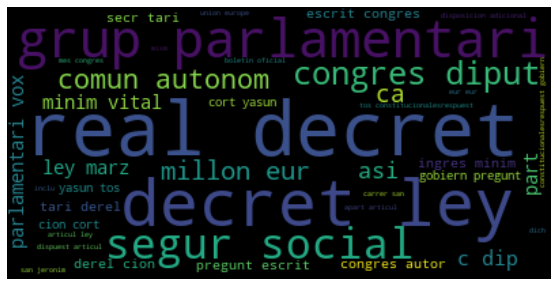

ODS10
(11585,)


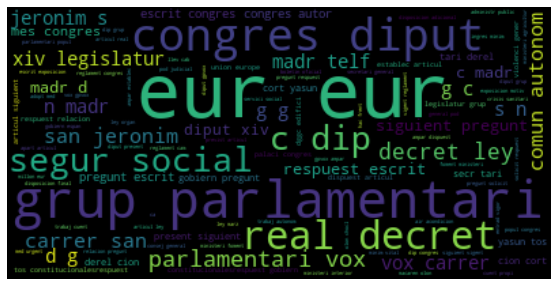

ODS11
(2357,)


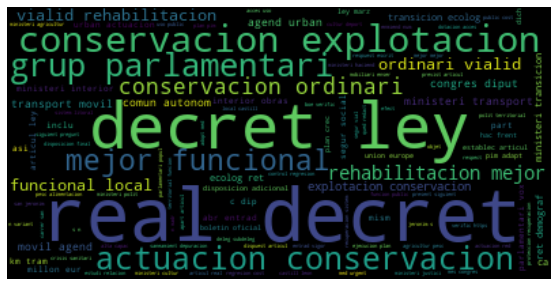

ODS12
(1374,)


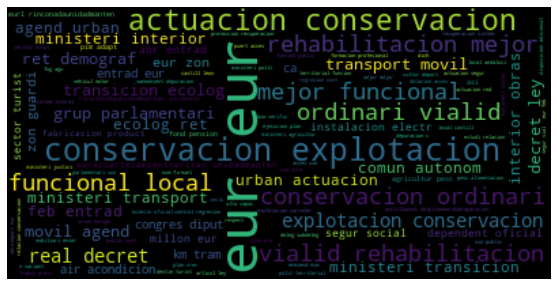

ODS13
(2120,)


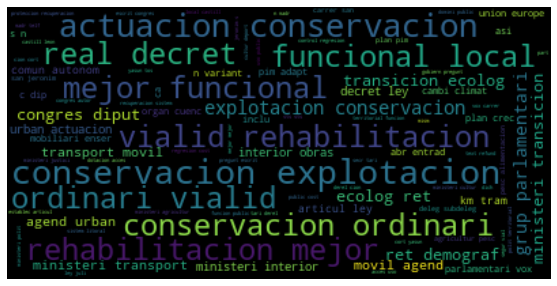

ODS14
(751,)


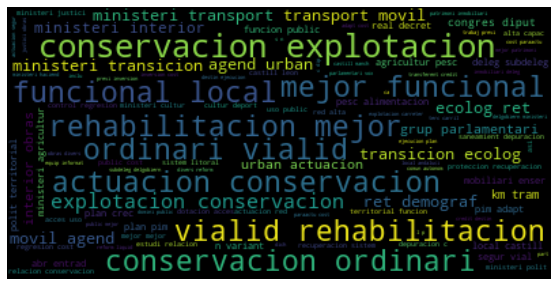

ODS15
(394,)


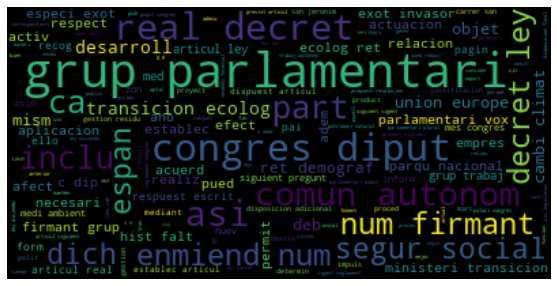

ODS16
(8785,)


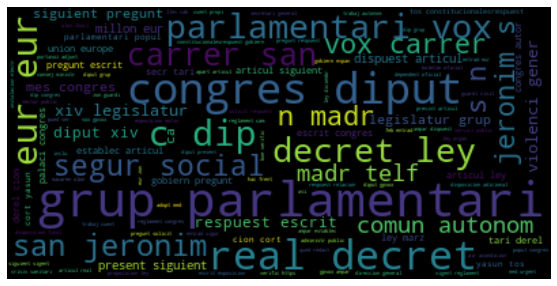

ODS17
(655,)


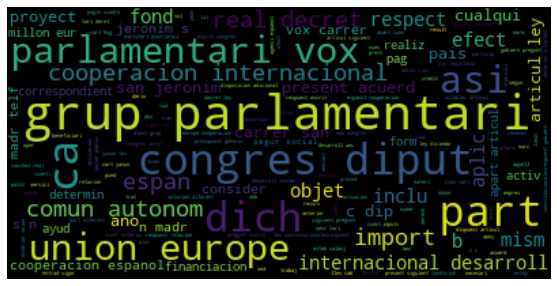

ODS2
(363,)


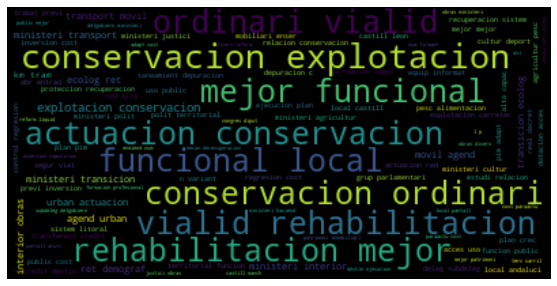

ODS3
(12811,)


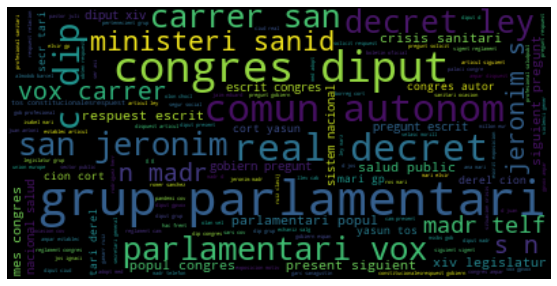

ODS4
(3997,)


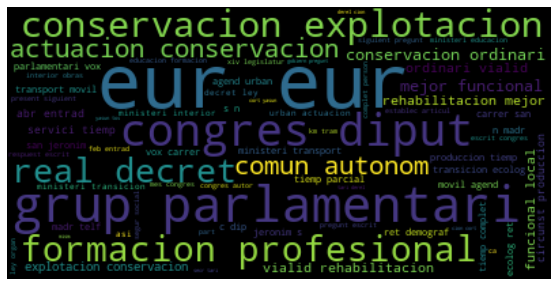

ODS5
(4428,)


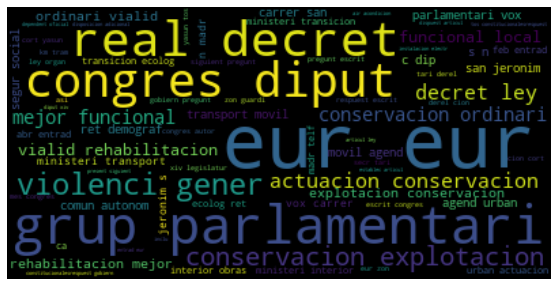

ODS6
(2060,)


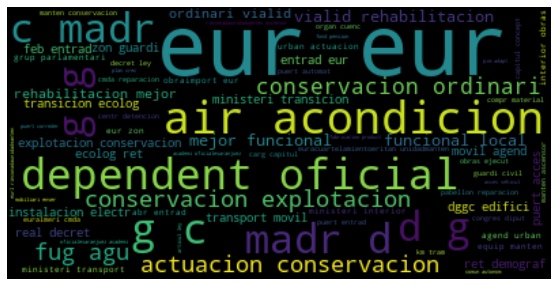

ODS7
(1982,)


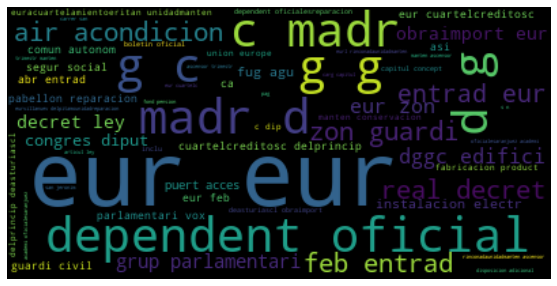

ODS8
(7099,)


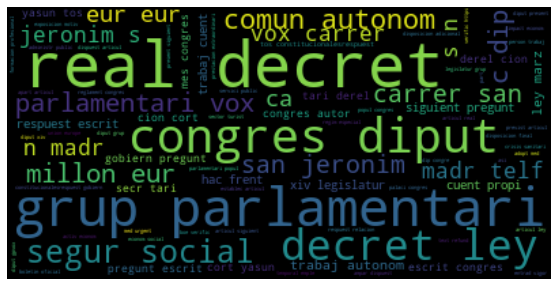

ODS9
(10272,)


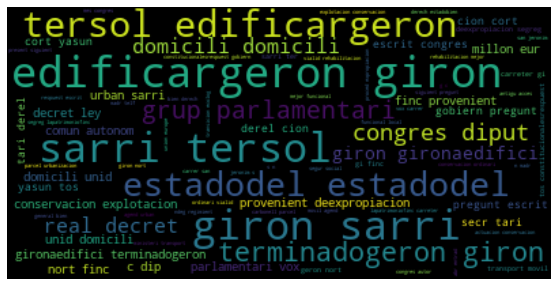

In [44]:
for cat in targets.columns:
    print(cat)
    subset = final_df[final_df[cat]==1]['t6_stemming']
    print(subset.shape)
    wordcloud = WordCloud().generate(' '.join(subset))
    plt.figure(figsize=(12,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Vectorize

In [22]:
vectorizer = CountVectorizer(#min_df = 0.00004, max_df = 0.97, stop_words = list(remove_words.Words)
vocabulary = final_words.Words
)
X = vectorizer.fit_transform(df['t6_stemming'])

In [23]:
res = pd.DataFrame(X.A, columns=vectorizer.get_feature_names(), dtype = np.int8)

In [24]:
res.shape

(108577, 5302)

In [25]:
res.head()

,marz,sistem,decret,espanol,legislatur,trafic,xiv,nuev,situacion,informacion,...,masafect,yemergent,suiz,indemn,atender,psa,laformacion,cortafueg,impediment,traduccion
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
xy = pd.concat([res.reset_index(drop=True), targets.reset_index(drop=True)], axis=1)

In [42]:
xy.to_csv('final_features.csv')